# Logistic Regression

This logistic regression is based on the Beeler/Daw et al. 2010 paper.
Specifically:

dependent variable: binary choice of port (-1 or 1)

explanatory variables: 
1. the N previous rewards $ r_{t-N:t-1} $
2. the previous choice $c_{t-1}$ to capture a tendency to stay or switch
3. bias variable (1) to capture fixed, overall preference for either port

Note: this model only carries information about ports when it gets a reward. IE -1 = right reward, 1 = left reward, but 0 = no reward (for either side). Should compare models with this information vs. added information about the non-rewarded port choices. 

## 02/19/2017
I just ran the above code on the following data:
    
- `full_9010_02192017.csv`
- `full_8020_02192017.csv`
- `full_7030_02192017.csv`

Which were computed by compiling the following data:
- block range: exactly 50 rewards
- p(choose high Port) >= [p-0.1] where p = p(high Port)

Observations:
1. pseudo-R2 also similar: ~0.64-0.69
2. For (1)  maybe a slight trend that 90-10 had a better model, but not certain. 
3. For each condition, I tried adding in more ports (up to 3) into the past to see if it would help out. For all 3 conditions, decisions for t-N where 2 >= 2 had coefficients = 0. That is, the only non-zero beta for the ports was the most recent one. 

Next step: 


**Figures**

1. Logistic regression performs similarly across different conditions
    - x axis: 90-10,80-20,70-30
    - y axis: F1 score, pseudo-R2
2. Comparing model flexibility across different conditions
    - x axis: number of previous rewards included (i.e. parameters in model)
    - y axis: BIC
    - color: each condition
3. Knowing where the non-rewarded trials are:
    - what if you did the same regression, but instead you know where the non-rewarded trials are?
    - also, compare to adding in previous ports (or rewards in the above scenario) and compare

4. Comparing 'strategies' across conditions
    - train on 90-10, test on 80-20 (and all combinations)

5. Comparing 'strategies' across mice
    - train on one mouse:condition pair, and test on another mouse:condition pair (for the same condition)
    


In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
import sklearn.tree
%matplotlib inline 

## define function to do logistic regression and some basic evalutions

In [2]:
'''
I compiled the code above into a more compact function so I can cycle through different conditions/mice/etc 
as neccessary
'''

def logreg_and_eval(data,num_rewards=10,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix)
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    features.append('1_Port') #append the last decision as a feature
    features.append('Decision') #finally append the decision so we can take it to predict later
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = d_test['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = d['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'stay':acc_pos,'switch':acc_neg,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features.append('Bias')
    
    coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)
    return logreg,stats,coefs

In [3]:
def logreg_and_eval_withports(data,num_rewards=10,num_ports=1,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix)
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    if num_rewards == 0:
        features = port_features[-1*num_ports:]
    elif num_ports == 0:
        features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    else:
        features = features[-1*num_rewards:]
        features = np.append(features,port_features[-1*num_ports:])
    
    print(features)
    features = np.append(features,'Decision') #finally append the decision so we can take it to predict later
    
    
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = test_data['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = data['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'stay':acc_pos,'switch':acc_neg,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features = np.append(features,'Bias')
    
    coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)
    return logreg,stats,coefs

# Write here

In [4]:
data_90 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_9010_02192017.csv',index_col=0)
data_80 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_8020_02192017.csv',index_col=0)
data_70 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_7030_02192017.csv',index_col=0)

datas = [data_70,data_80,data_90]
models = []

In [16]:
for i,d in enumerate(datas):
    
    for j in range(30):
        model_curr,stats_curr,coefs_curr = logreg_and_eval(d,num_rewards=7)
        models.append(models)

        if ((i == 0 and j == 0)):
            stats = stats_curr.copy()
            coefs = coefs_curr.copy()
        else:
            stats = stats.append(stats_curr)
            coefs = coefs.append(coefs_curr)

c = np.zeros(90)+70
c[30:] = 80
c[60:] = 90

stats.insert(0,'Condition',c)
coefs.insert(0,'Condition',c)

Optimization terminated successfully.
         Current function value: 0.241744
         Iterations 8
          Predicted NO  Predicted YES
True NO         4852.0           25.0
True YES         456.0           24.0

F1: 0.091

Accuracy on class 0: 0.99
Accuracy on class 1: 0.05

Optimization terminated successfully.
         Current function value: 0.239710
         Iterations 8
          Predicted NO  Predicted YES
True NO         4856.0           19.0
True YES         458.0           24.0

F1: 0.091

Accuracy on class 0: 1.00
Accuracy on class 1: 0.05

Optimization terminated successfully.
         Current function value: 0.234558
         Iterations 8
          Predicted NO  Predicted YES
True NO         4818.0           36.0
True YES         476.0           27.0

F1: 0.095

Accuracy on class 0: 0.99
Accuracy on class 1: 0.05

Optimization terminated successfully.
         Current function value: 0.236607
         Iterations 8
          Predicted NO  Predicted YES
True NO         4

In [17]:
stats

,Condition,Accuracy,BIC,negative loglikelihood,pseudo-R2,stay,switch
0,70.0,0.910211,6118.572817,3021.552793,0.651162,0.050000,0.994874
0,70.0,0.910958,6067.733195,2996.132982,0.654120,0.049793,0.996103
0,70.0,0.904424,5938.949807,2931.741288,0.661603,0.053678,0.992583
0,70.0,0.903117,5990.162876,2957.347823,0.658648,0.037037,0.994839
0,70.0,0.911704,6182.803821,3053.668295,0.647527,0.046809,0.994884
0,70.0,0.903864,6043.498302,2984.015535,0.655529,0.045726,0.992789
0,70.0,0.906478,5993.544329,2959.038549,0.658445,0.066802,0.991775
0,70.0,0.904797,6013.952072,2969.242420,0.657185,0.073267,0.991344
0,70.0,0.905357,5955.093329,2939.813049,0.660657,0.050193,0.996900
0,70.0,0.905731,6011.064749,2967.798759,0.657442,0.046278,0.993621


In [36]:
acc_9010 = stats[stats['Condition']==70]['stay'].mean()

In [37]:
acc_9010

0.057853209795639314

In [38]:
d = {'condition':['90-10','90-10','90-10','80-20','80-20','80-20','70-30','70-30','70-30'],
    'accuracy': [0.91,0.98,0.18,0.90,0.99,0.10,0.90,0.99,0.05],
     'type':['overall','stay','switch','overall','stay','switch','overall','stay','switch']
    }

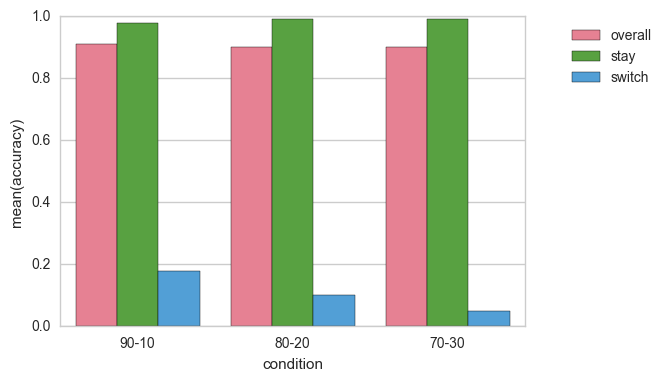

In [39]:
master_stats = pd.DataFrame(data=d,index=None)
sns.set_style('whitegrid')
sns.barplot(x='condition',y='accuracy',data=master_stats,hue='type',palette='husl')
plt.legend(bbox_to_anchor=(1.3,1))

# Comparing beta coefficients across conditions

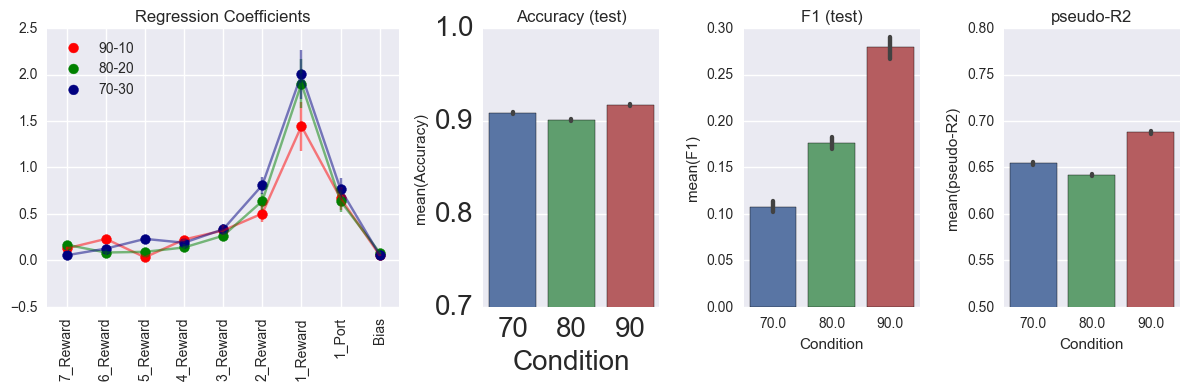

In [50]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,4,width_ratios=[2,1,1,1])

plt.subplot(gs[0])
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='red',alpha=0.5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='green',alpha=0.5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='navy',alpha=0.5)

plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
            color='red',label='90-10',s=50)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
            color='green',label='80-20',s=50)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
            color='navy',label='70-30',s=50)

plt.legend(loc='upper left')
plt.xticks(np.arange(coefs.shape[1]),coefs.columns.values[1:],rotation='vertical')
plt.xlim(-0.5,8.5)
plt.title('Regression Coefficients')

plt.subplot(gs[1])
sns.barplot(x='Condition',y='Accuracy',data=stats)
plt.title('Accuracy (test)')
plt.xticks([0,1,2],['70','80','90'],fontsize=20)
plt.yticks([0.7,0.8,0.9,1.0],fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylim(0.7,1)

plt.subplot(gs[2])
sns.barplot(x='Condition',y='F1',data=stats)
plt.title('F1 (test)')
#plt.ylim(0.7,1)

plt.subplot(gs[3])
sns.barplot(x='Condition',y='pseudo-R2',data=stats)
plt.title('pseudo-R2')
plt.ylim(0.5,0.8)

plt.tight_layout()

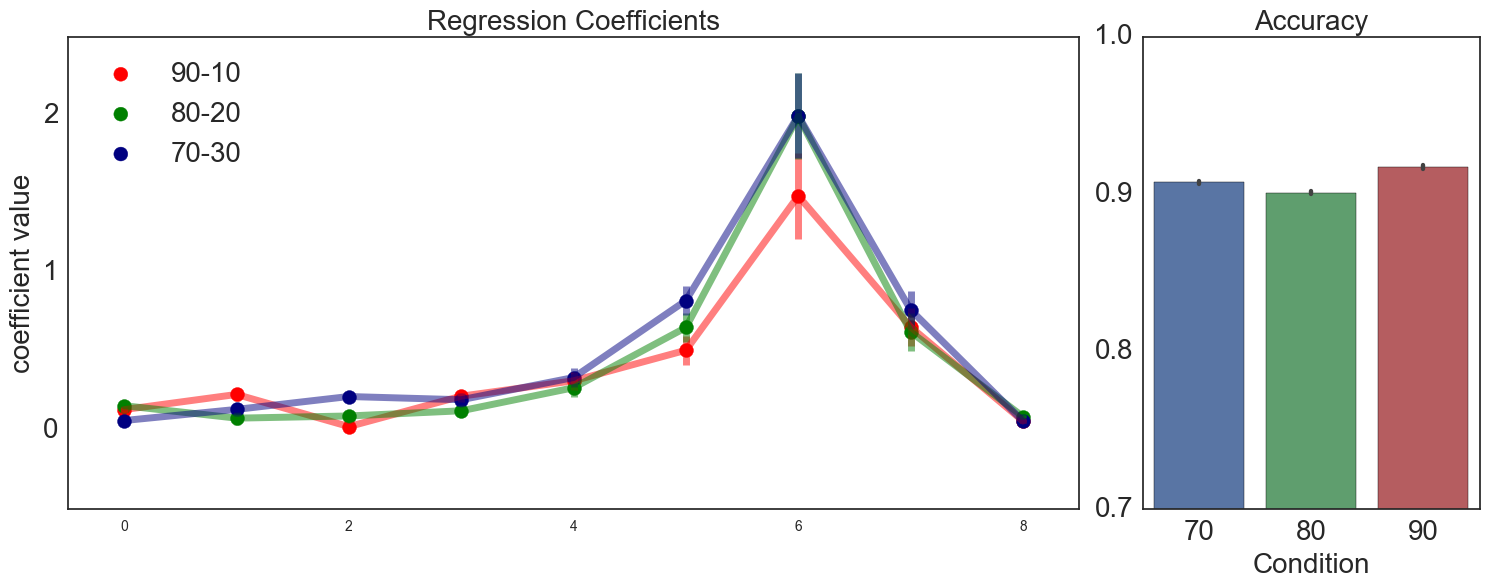

In [9]:
sns.set_style('white')
plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1,2,width_ratios=[3,1])

plt.subplot(gs[0])
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='red',alpha=0.5,linewidth=5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='green',alpha=0.5,linewidth=5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='navy',alpha=0.5,linewidth=5)

plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
            color='red',label='90-10',s=100)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
            color='green',label='80-20',s=100)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
            color='navy',label='70-30',s=100)

plt.legend(loc='upper left',fontsize=20)
#plt.xticks(np.arange(coefs.shape[1]),coefs.columns.values[1:],rotation='vertical')
plt.xlabel('')
plt.yticks([0,1,2],fontsize=20)
plt.ylabel('coefficient value',fontsize=20)
plt.xlim(-0.5,8.5)
plt.title('Regression Coefficients',fontsize=20)

plt.subplot(gs[1])
sns.barplot(x='Condition',y='Accuracy',data=stats)
plt.title('Accuracy',fontsize=20)
plt.xticks([0,1,2],['70','80','90'],fontsize=20)
plt.yticks([0.7,0.8,0.9,1.0],fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylabel('')
plt.ylim(0.7,1)

plt.tight_layout()

## Test number of parameters / model flexibility vs BIC

In [7]:
stats.head(2)

,Condition,Accuracy,BIC,F1,negative loglikelihood,pseudo-R2
0,70.0,0.909838,6035.178663,0.065764,2979.855716,0.656046
0,70.0,0.909091,6034.395852,0.086304,2979.464311,0.656057


In [8]:
d = data_80.copy()
stats = pd.DataFrame(columns=['Accuracy','BIC','negative loglikelihood','pseudo-R2','No. parameters'])

for i,n in enumerate(np.arange(10,0,-1)):
    
    for j in enumerate(range(30)):
        model_curr,stats_curr,coefs_curr = logreg_and_eval(d,num_rewards=n)
        models.append(models)
        stats_curr['No. parameters'] = n
        stats = stats.append(stats_curr)

Optimization terminated successfully.
         Current function value: 0.246039
         Iterations 8
          Predicted NO  Predicted YES
True NO        13017.0          177.0
True YES        1272.0          188.0

F1: 0.206

Accuracy on class 0: 0.99
Accuracy on class 1: 0.13

Optimization terminated successfully.
         Current function value: 0.246079
         Iterations 8
          Predicted NO  Predicted YES
True NO        13012.0          147.0
True YES        1342.0          153.0

F1: 0.170

Accuracy on class 0: 0.99
Accuracy on class 1: 0.10

Optimization terminated successfully.
         Current function value: 0.246265
         Iterations 8
          Predicted NO  Predicted YES
True NO        13041.0          108.0
True YES        1367.0          138.0

F1: 0.158

Accuracy on class 0: 0.99
Accuracy on class 1: 0.09

Optimization terminated successfully.
         Current function value: 0.244487
         Iterations 8
          Predicted NO  Predicted YES
True NO        13

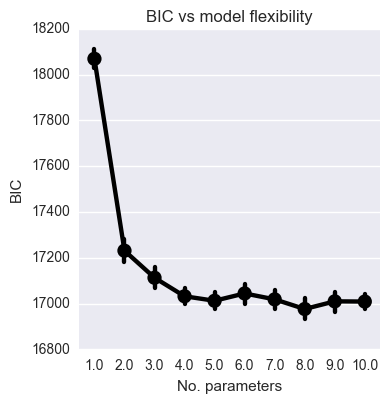

In [9]:
plt.figure(figsize=(10,4))
sns.factorplot(x='No. parameters',y='BIC',data=stats,color='black')
plt.title('BIC vs model flexibility')

In [10]:
BIC = np.zeros((10,10))
F1 = np.zeros((10,10))
R2 = np.zeros((10,10))
acc = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        if not ((j==0) & (i==0)):
            model_curr,stats_curr,coefs_curr = logreg_and_eval_withports(d,num_rewards=i,num_ports=j)
            BIC[i,j] = stats_curr['BIC'].values
            F1[i,j] = stats_curr['F1'].values
            R2[i,j] = stats_curr['pseudo-R2'].values
            acc[i,j] = stats_curr['Accuracy'].values

['1_Port']
Optimization terminated successfully.
         Current function value: 0.324176
         Iterations 6
          Predicted NO  Predicted YES
True NO        13175.0            0.0
True YES        1479.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

['2_Port', '1_Port']
Optimization terminated successfully.
         Current function value: 0.313950
         Iterations 6
          Predicted NO  Predicted YES
True NO        13193.0            0.0
True YES        1461.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

['3_Port', '2_Port', '1_Port']
Optimization terminated successfully.
         Current function value: 0.310537
         Iterations 6
          Predicted NO  Predicted YES
True NO        13171.0            0.0
True YES        1483.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: 0.00

['4_Port', '3_Port', '2_Port', '1_Port']
Optimization terminated successfully.
         Curren

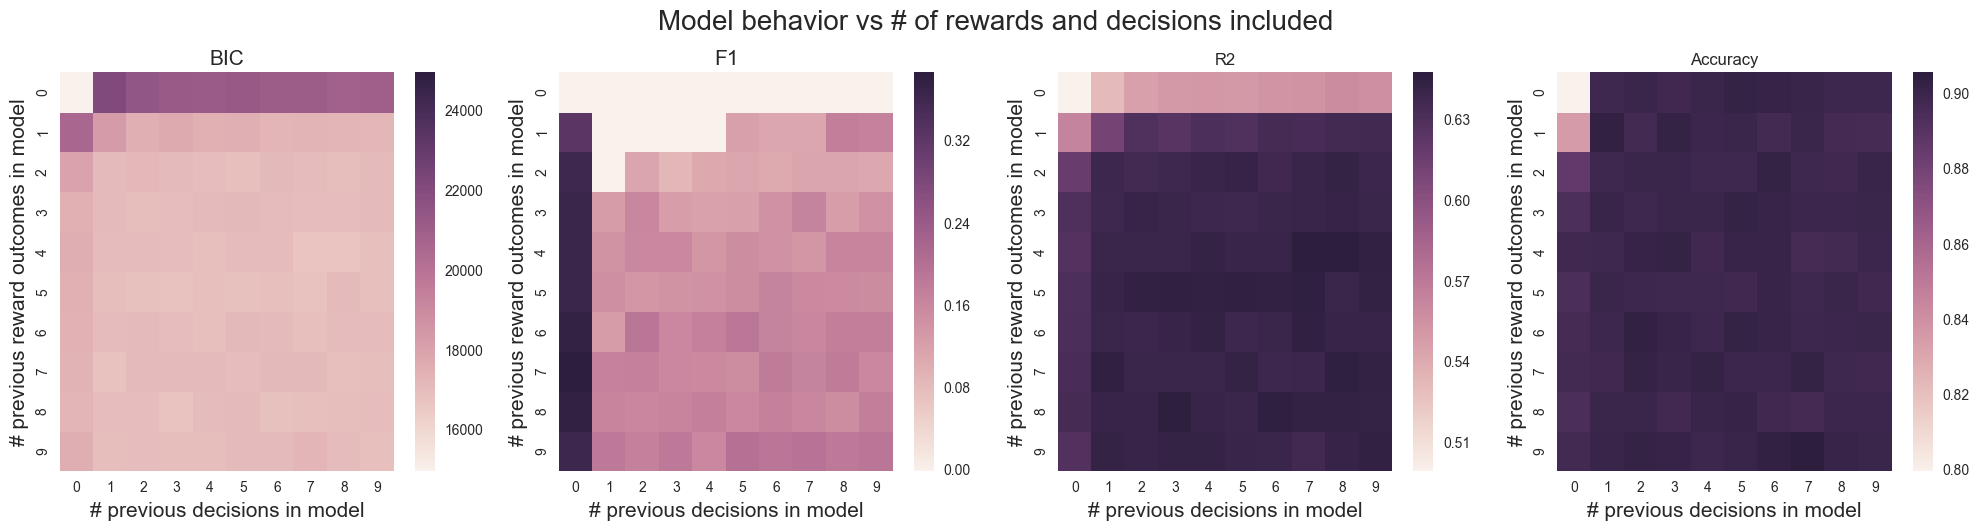

In [11]:
plt.figure(figsize=(20,5))
plt.suptitle('Model behavior vs # of rewards and decisions included',x=0.5,y=1.05,fontsize=20)

plt.subplot(141)
sns.heatmap(BIC,vmin=15000,vmax=25000)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('BIC',fontsize=15)

plt.subplot(142)
sns.heatmap(F1)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('F1',fontsize=15)

plt.subplot(143)
sns.heatmap(R2,vmin=0.5)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('R2')

plt.subplot(144)
sns.heatmap(acc,vmin=0.8)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('Accuracy')

plt.tight_layout()

# Training / testing on different conditions

### 1. Train on 90-10, test on 80-20 and 70-30

In [12]:
for i,d in enumerate([data_90,data_80,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_90,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_90 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

Optimization terminated successfully.
         Current function value: 0.215178
         Iterations 8
          Predicted NO  Predicted YES
True NO         2909.0           53.0
True YES         216.0           58.0

F1: 0.301

Accuracy on class 0: 0.98
Accuracy on class 1: 0.21

Optimization terminated successfully.
         Current function value: 0.216107
         Iterations 8
          Predicted NO  Predicted YES
True NO        42740.0         1221.0
True YES        3758.0         1126.0

F1: 0.311

Accuracy on class 0: 0.97
Accuracy on class 1: 0.23

Optimization terminated successfully.
         Current function value: 0.216107
         Iterations 8
          Predicted NO  Predicted YES
True NO        15852.0          361.0
True YES        1350.0          293.0

F1: 0.255

Accuracy on class 0: 0.98
Accuracy on class 1: 0.18



In [13]:
stats_90['Testing Condition'] = [90,80,70]
stats_90

,Accuracy,F1,Testing Condition
0,0.916873,0.301299,90
0,0.898065,0.311437,80
0,0.904178,0.255115,70


So this is interesting - accuracy stays pretty much the same across conditions, but F1 goes way down. And if we take a look at the confusion tables above, we can see it is because the accuracy on the switches went down (and accuracy on stays went up. 

### 2. Train on 80-20

In [14]:
for i,d in enumerate([data_80,data_90,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_80,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_80 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_80['Testing Condition'] = [80,90,70]
stats_80

Optimization terminated successfully.
         Current function value: 0.246867
         Iterations 8
          Predicted NO  Predicted YES
True NO        13070.0          123.0
True YES        1325.0          136.0

F1: 0.158

Accuracy on class 0: 0.99
Accuracy on class 1: 0.09

Optimization terminated successfully.
         Current function value: 0.247334
         Iterations 8
          Predicted NO  Predicted YES
True NO         9640.0          235.0
True YES         658.0          253.0

F1: 0.362

Accuracy on class 0: 0.98
Accuracy on class 1: 0.28

Optimization terminated successfully.
         Current function value: 0.247334
         Iterations 8
          Predicted NO  Predicted YES
True NO        15851.0          362.0
True YES        1348.0          295.0

F1: 0.257

Accuracy on class 0: 0.98
Accuracy on class 1: 0.18



,Accuracy,F1,Testing Condition
0,0.901187,0.158140,80
0,0.917207,0.361687,90
0,0.904234,0.256522,70


### 3. Train on 70-30

In [15]:
for i,d in enumerate([data_70,data_80,data_90]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_70,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_70 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_70['Testing Condition'] = [70,80,90]
stats_70

Optimization terminated successfully.
         Current function value: 0.237905
         Iterations 8
          Predicted NO  Predicted YES
True NO         4844.0           27.0
True YES         451.0           35.0

F1: 0.128

Accuracy on class 0: 0.99
Accuracy on class 1: 0.07

Optimization terminated successfully.
         Current function value: 0.238406
         Iterations 8
          Predicted NO  Predicted YES
True NO        42851.0         1110.0
True YES        3808.0         1076.0

F1: 0.304

Accuracy on class 0: 0.97
Accuracy on class 1: 0.22

Optimization terminated successfully.
         Current function value: 0.238406
         Iterations 8
          Predicted NO  Predicted YES
True NO         9649.0          226.0
True YES         662.0          249.0

F1: 0.359

Accuracy on class 0: 0.98
Accuracy on class 1: 0.27



,Accuracy,F1,Testing Condition
0,0.910771,0.127737,70
0,0.899314,0.304385,80
0,0.917671,0.359307,90


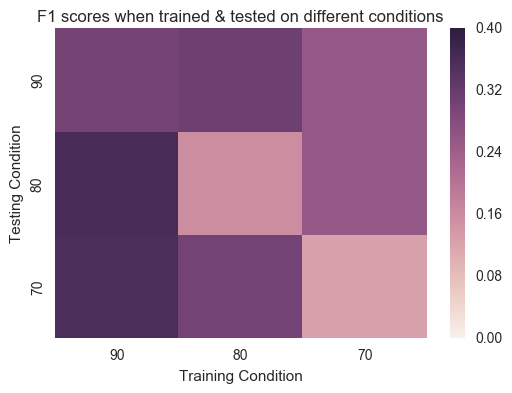

In [16]:
f1s = np.vstack((stats_90['F1'].values,
               stats_80['F1'].values[[1,0,2]],
               stats_70['F1'].values[[2,1,0]]))
sns.heatmap(f1s,vmin=0,vmax=0.4)
plt.xticks([0.5,1.5,2.5],['90','80','70'])
plt.yticks([0.5,1.5,2.5],['70','80','90'])
plt.ylabel('Testing Condition')
plt.xlabel('Training Condition')
plt.title('F1 scores when trained & tested on different conditions')

So if this is right, it means that the rules are different - what predicts a switch in 90-10 does not predict a switch in 80-20. But since most of the trials follow the last one, the accuracy doesn't drop very much. So it appears to be working fine, even though it is not. 

Can the difference be explained in the small differences in beta coefficient values? It must be ... what else is there? They seem similar enough that I'm surprised it makes such a difference. 

Let's go on to train and test on separate mice:

# Train/test on separate mice

First let's take a quick look at the mice's performances - specifically just at p(choose high P port):

In [17]:
data_90.insert(0,'Condition',0.9)
data_80.insert(0,'Condition',0.8)
data_70.insert(0,'Condition',0.7)

In [18]:
all_data = data_90.append(data_80)
all_data = all_data.append(data_70)
all_data.shape

(77487, 51)

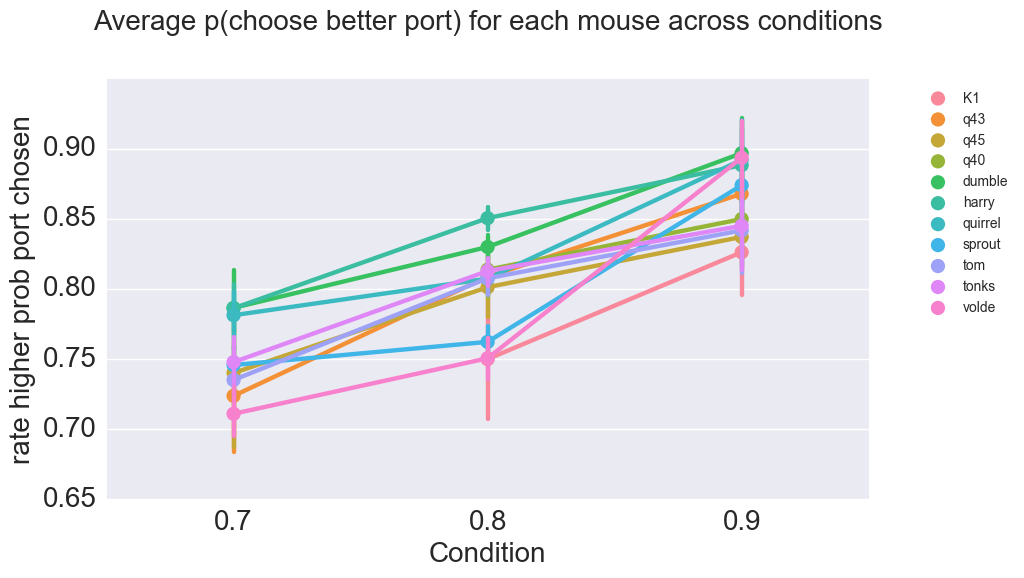

In [19]:
sns.factorplot(x='Condition',y='Higher p port',hue='Mouse ID',data = all_data,legend=False,size=5,aspect=1.7)
plt.legend(bbox_to_anchor=(1.2,1))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylabel('rate higher prob port chosen',fontsize=20)
plt.title('Average p(choose better port) for each mouse across conditions',fontsize=20,x=0.5,y=1.1)

Okay, so based on this. Let's start with 80-20, and do a few different comparisons. 

1. Start by training with harry, and testing on all the others. 
2. Then try training on volde, testing on all others. 
3. Finally train on someone in the middle - like Tom or q45, and test on others

In [20]:
'''
Loop through mice
'''
mice = np.unique(data_80['Mouse ID'].values)

stats = pd.DataFrame(columns=['Accuracy','F1','Training Mouse','Testing Mouse'])
test_mice = []
train_mice = []

for mouse_train in mice:

    d_train = data_80[data_80['Mouse ID'] == mouse_train].copy()

    for i,mouse_test in enumerate(mice):
        d_test = data_80[data_80['Mouse ID'] == mouse_test].copy()

        if i == 0:
            model,stats_curr,coefs = logreg_and_eval(d_train,test_data = d_test)
            stats_curr = stats_curr.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)
            stats = stats.append(stats_curr)
        else:
            model,stats_curr,coefs_curr = logreg_and_eval(d_train,test_data = d_test)
            stats_curr = stats_curr.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)
            stats= stats.append(stats_curr)
            coefs = coefs.append(coefs_curr)

        test_mice.append(mouse_test)
        train_mice.append(mouse_train)

stats['Testing Mouse'] = test_mice
stats['Training Mouse'] = train_mice
acc_matrix = np.reshape(stats['Accuracy'].values,(len(mice),-1)).T
F1_matrix = np.reshape(stats['F1'].values,(len(mice),-1)).T

Optimization terminated successfully.
         Current function value: 0.383550
         Iterations 7
          Predicted NO  Predicted YES
True NO          323.0           16.0
True YES          50.0           31.0

F1: 0.484

Accuracy on class 0: 0.95
Accuracy on class 1: 0.38

Optimization terminated successfully.
         Current function value: 0.383550
         Iterations 7
          Predicted NO  Predicted YES
True NO         5755.0          249.0
True YES         417.0          172.0

F1: 0.341

Accuracy on class 0: 0.96
Accuracy on class 1: 0.29

Optimization terminated successfully.
         Current function value: 0.383550
         Iterations 7
          Predicted NO  Predicted YES
True NO         6167.0          153.0
True YES         328.0          116.0

F1: 0.325

Accuracy on class 0: 0.98
Accuracy on class 1: 0.26

Optimization terminated successfully.
         Current function value: 0.383550
         Iterations 7
          Predicted NO  Predicted YES
True NO         1

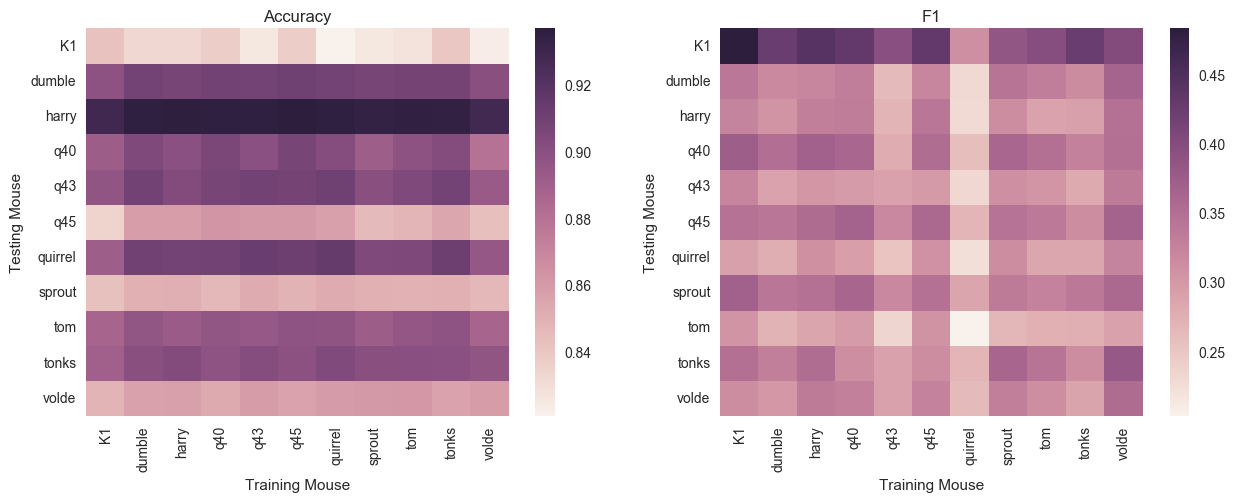

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.heatmap(acc_matrix)
plt.xticks(np.arange(11)+0.5,mice,rotation='vertical')
plt.yticks(np.arange(11)+0.5,mice[::-1],rotation='horizontal')
plt.xlabel('Training Mouse')
plt.ylabel('Testing Mouse')
plt.title('Accuracy')

plt.subplot(122)
sns.heatmap(F1_matrix)
plt.xticks(np.arange(11)+0.5,mice,rotation='vertical')
plt.yticks(np.arange(11)+0.5,mice[::-1],rotation='horizontal')
plt.xlabel('Training Mouse')
plt.ylabel('Testing Mouse')
plt.title('F1')

In [22]:
data_80.head(2)

,Condition,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,...,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward
0,0.8,K1,11212016_K1,11.0,1.0,1.0,-1.0,1.0,1.993,0.727,...,0.524,-1.0,1.0,1.303,0.573,1.952,0.0,0.0,1.0,1.0
1,0.8,K1,11212016_K1,12.0,2.0,2.0,-1.0,1.0,1.729,0.894,...,0.573,-1.0,1.0,1.952,0.445,2.681,0.0,0.0,1.0,1.0


In [23]:
u_switch = np.zeros(len(mice))
u_acc = np.zeros(len(mice))

for i,mouse in enumerate(mice):
    u_switch[i] = data_80[data_80['Mouse ID']== mouse]['Switch'].mean()
    u_acc[i] = data_80[data_80['Mouse ID']== mouse]['Higher p port'].mean()

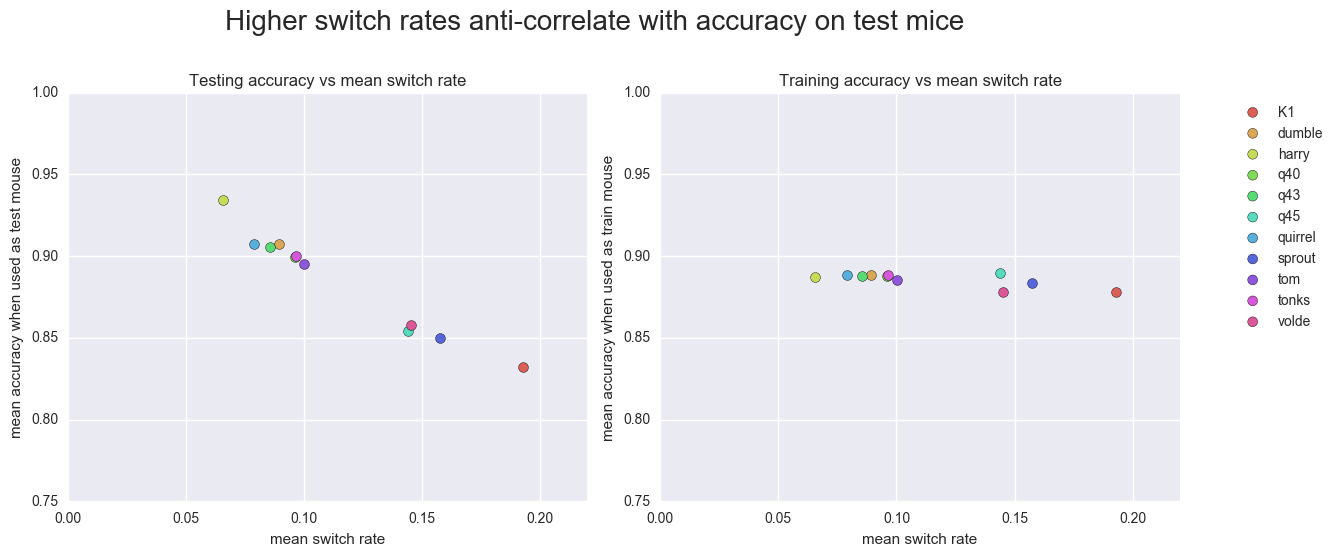

In [24]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Higher switch rates anti-correlate with accuracy on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],acc_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean accuracy when used as test mouse')
plt.ylim(0.75,1)
plt.xlim(0,0.22)
plt.title('Testing accuracy vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],acc_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean accuracy when used as train mouse')
plt.ylim(0.75,1)
plt.xlim(0,0.22)
plt.title('Training accuracy vs mean switch rate')

plt.tight_layout()

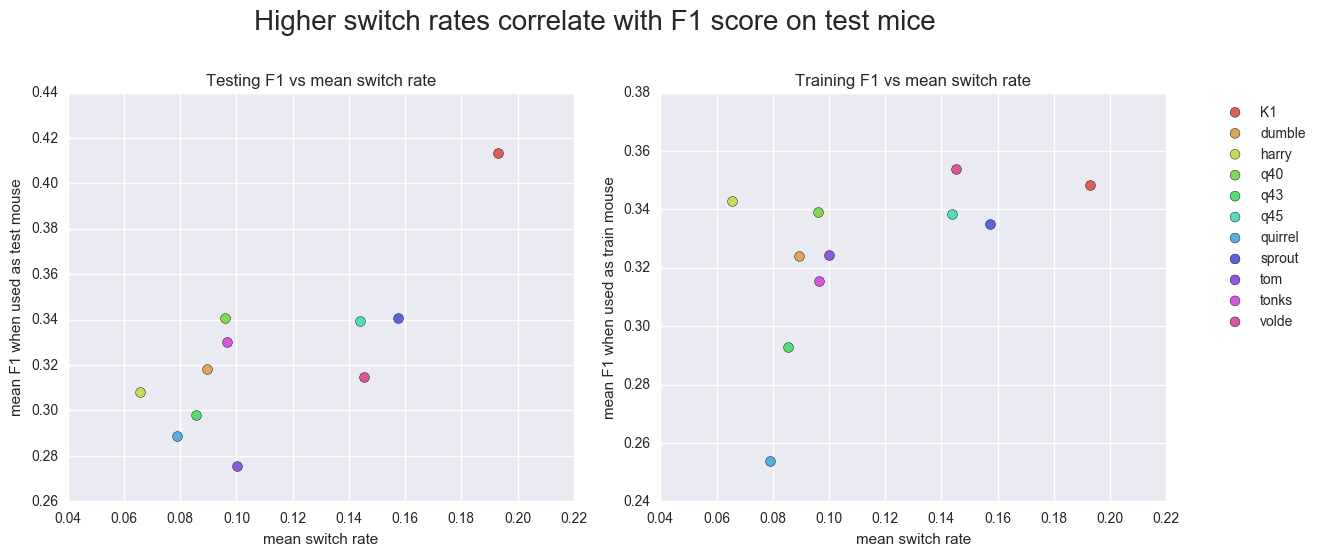

In [25]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Higher switch rates correlate with F1 score on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],F1_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean F1 when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing F1 vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],F1_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean F1 when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training F1 vs mean switch rate')

plt.tight_layout()

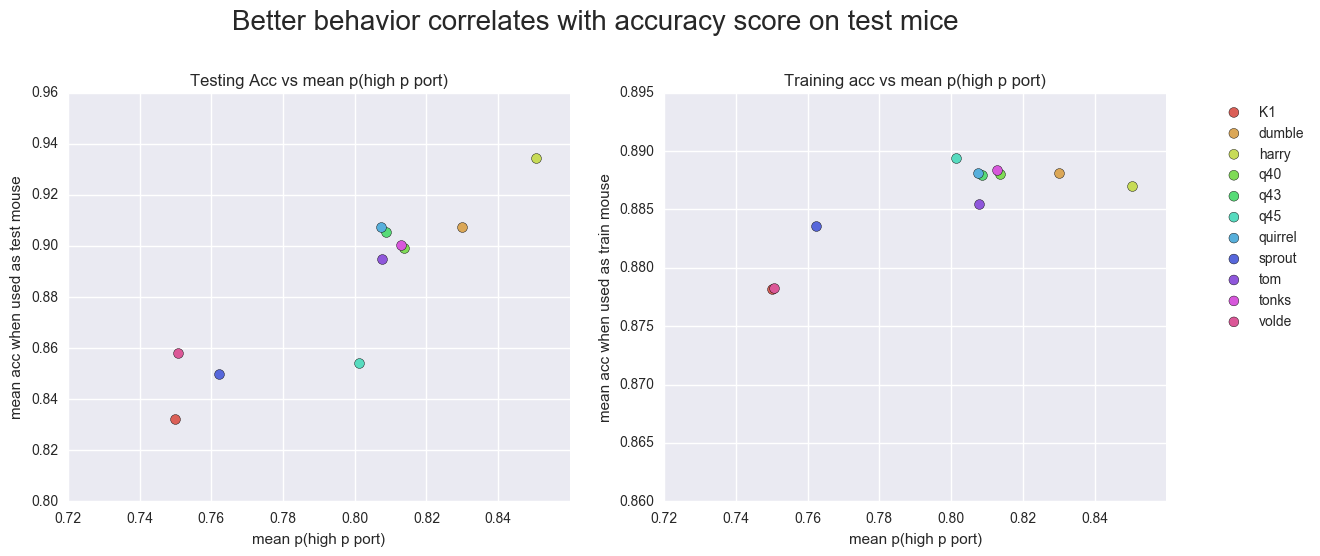

In [26]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Better behavior correlates with accuracy score on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],acc_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean p(high p port)')
plt.ylabel('mean acc when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing Acc vs mean p(high p port)')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],acc_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean p(high p port)')
plt.ylabel('mean acc when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training acc vs mean p(high p port)')

plt.tight_layout()

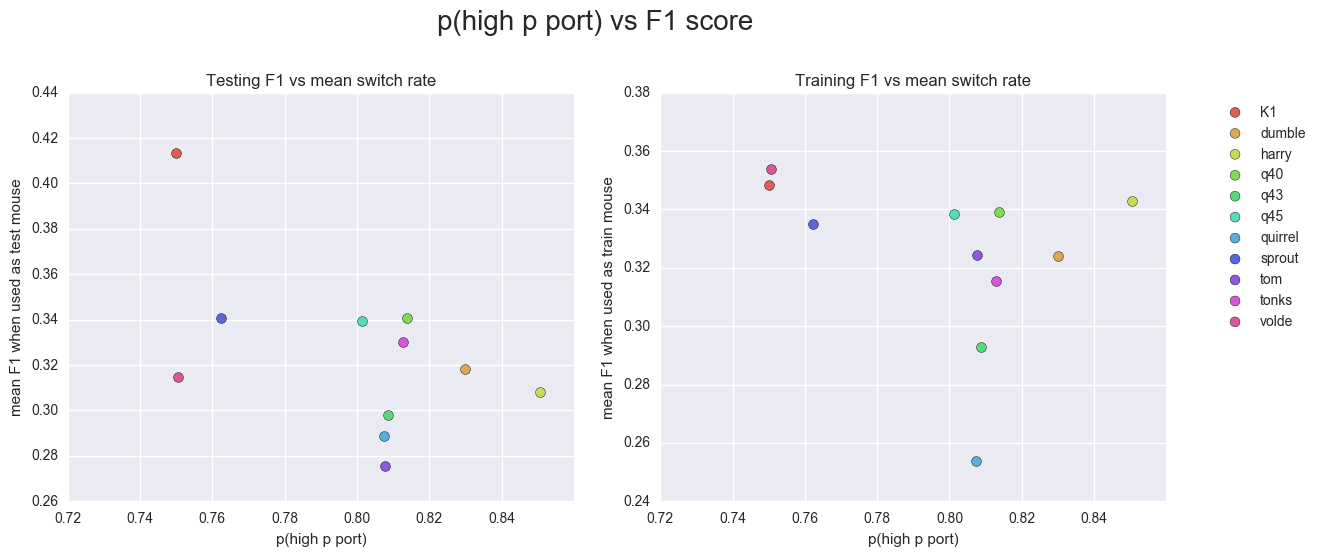

In [27]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('p(high p port) vs F1 score',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],F1_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('p(high p port)')
plt.ylabel('mean F1 when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing F1 vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],F1_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('p(high p port)')
plt.ylabel('mean F1 when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training F1 vs mean switch rate')

plt.tight_layout()

# Trying interaction terms

In [6]:
from sklearn.preprocessing import PolynomialFeatures

In [10]:
poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias=True)

In [25]:
def logreg_and_eval_withports_and_interactions(data,num_rewards=10,num_ports=1,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix) with interactions
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    if num_rewards == 0:
        features = port_features[-1*num_ports:]
    elif num_ports == 0:
        features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    else:
        features = features[-1*num_rewards:]
        features = np.append(features,port_features[-1*num_ports:])
    
    print(features)
    features = np.append(features,'Decision') #finally append the decision so we can take it to predict later
    
    
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = test_data['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = data['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #create interaction terms
    poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias=True)
    x_train = poly.fit_transform(x_train)
    x_test = poly.fit_transform(x_test)
    print('x_train shape: %.0f' % x_train.shape[1])
    
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'stay':acc_pos,'switch':acc_neg,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features = np.append(features,'Bias')
    
    #coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=poly.get_feature_names())
    return logreg,stats

In [26]:
model,stats_curr = logreg_and_eval_withports_and_interactions(data_80,num_rewards = 5)

['5_Reward' '4_Reward' '3_Reward' '2_Reward' '1_Reward' '1_Port']
x_train shape: 22
Optimization terminated successfully.
         Current function value: 0.246633
         Iterations 8
          Predicted NO  Predicted YES
True NO        13045.0          119.0
True YES        1340.0          150.0

F1: 0.171

Accuracy on class 0: 0.99
Accuracy on class 1: 0.10



In [31]:
model.coef_.shape[1]

22

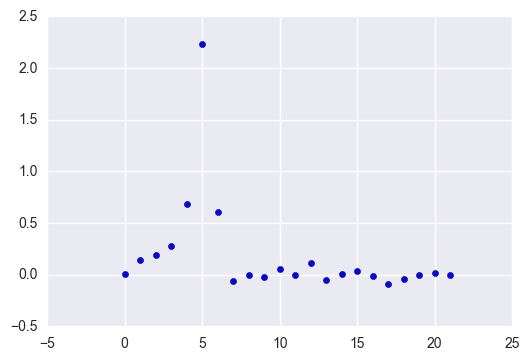

In [32]:
plt.scatter(np.arange(model.coef_.shape[1]),model.coef_)